RandomForestClassifier를 GridSearch를 통해 파라메터 최적화

In [1]:
import numpy as np
import cv2
import os
import itertools
import time

#for graphic
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline
# Load pandas
import pandas as pd
# Load numpy
import numpy as np
# Set random seed
np.random.seed(0)

# Load scikit's random forest classifier library
#load classifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#load utility
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def reshape_image(img):
    return np.asarray(np.reshape(img,len(img) * len(img[0])))

In [3]:
def readDataset(dataRootDir, df, kindOfClass):
    idx = 1 
    for path, subdir, files in os.walk(dataRootDir):
        for name in files :
            input_files = os.path.join(path,name)
            img = cv2.imread(input_files)
            if img.shape[0] != 120 or img.shape[1] != 100 :
                print("img {} is note valid {} ".format(name,img.shape))
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
            idx += 1            
            df.loc[len(df.index)+1] = [gray, kindOfClass]

    print("load ok data : {}".format(idx))
    return df

In [4]:
df = pd.DataFrame(columns=('img','class'))

In [5]:
dataRootDir = "/Users/mins/Documents/mv/ps/dataset/segment2"

In [6]:
#ok data 경로 설정 
okDataDir = os.path.join(dataRootDir, "ok")
#ng data 경로 설정 
ngDataDir = os.path.join(dataRootDir, "ng")

#ok data loadging
print("Load ok data")
df = readDataset(okDataDir, df, 0)

print("Load ng data")
#ng data loadging
df = readDataset(ngDataDir, df, 1)

Load ok data
img 14_161901-6_3.jpg is note valid (120, 94, 3) 
img 19_114029-6_1.jpg is note valid (120, 90, 3) 
img 19_114029-6_4.jpg is note valid (120, 90, 3) 
load ok data : 1022
Load ng data
img 14_161901-6_6.jpg is note valid (120, 94, 3) 
load ok data : 212


In [7]:
imglist = df['img'].tolist()
nImgCount = len(imglist)
xlen = len(imglist[0])
ylen = len(imglist[0][0])

X = np.zeros((nImgCount, xlen*ylen))
             
for i in range(0,nImgCount):
    X[i] = reshape_image(imglist[i])
    
Y = df['class'].astype(int).tolist()
Y = np.asarray(Y)
x_train, x_test, y_train, y_test = train_test_split(X,Y)
print("X:{}".format(len(X)))
print("Y:{}".format(len(Y)))
print("x_train:{}, y_train:{}".format(len(x_train),len(y_train)))
print("x_test:{} , y_test:{}".format(len(x_test), len(y_test)))
print("x_train: class 0 {}, x_train: class 1 :{}".format(np.count_nonzero(y_train==0),np.count_nonzero(y_train==1)))

X:1232
Y:1232
x_train:924, y_train:924
x_test:308 , y_test:308
x_train: class 0 762, x_train: class 1 :162


graph Utility

In [8]:
def draw_prcurve(test, score, color, label):
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    from sklearn.metrics import average_precision_score
    
    average_precision = average_precision_score(test, score)

    precision, recall, _ = precision_recall_curve(test, score)
    print("{} P:{} R:{}".format(label, precision, recall))
    
    
    plt.step(recall, precision, color=color, alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
              average_precision))
    

In [9]:
def plot_ROC(clf, x_test, y_test):
    probs = clf.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
def test_model2(clf, x_test, y_test):   
   
    y_pred = clf.predict(x_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    class_names = ["OK","NG"]
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

Grid Search

In [12]:
tuned_parameters = [
    {'criterion': ['gini'],    'max_depth': [3,5,7,9],
     'n_estimators': [8,32,128,512], 'n_jobs':[-1], 
     'class_weight':['balanced',{0:0.4, 1:0.6},{0:0.3, 1:0.7},{0:0.2, 1:0.8}]},
    {'criterion': ['entropy'], 'max_depth': [3,5,7,9],
     'n_estimators': [8,32,128,512], 
     'n_jobs':[-1],
     'class_weight':['balanced',{0:0.4, 1:0.6},{0:0.3, 1:0.7},{0:0.2, 1:0.8}]}
]

In [13]:
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'class_weight': {0: 0.3, 1: 0.7}, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 32, 'n_jobs': -1}

Grid scores on development set:

0.884 (+/-0.046) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 8, 'n_jobs': -1}
0.892 (+/-0.066) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 32, 'n_jobs': -1}
0.904 (+/-0.054) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 128, 'n_jobs': -1}
0.905 (+/-0.057) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 512, 'n_jobs': -1}
0.909 (+/-0.057) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 8, 'n_jobs': -1}
0.927 (+/-0.058) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 32, 'n_jobs': -1}
0.930 (+/-0.055) for {'class_weight': 'balance

Best parameters set found on development set:

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 512, 'n_jobs': -1}

Grid scores on development set:

0.878 (+/-0.066) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 8, 'n_jobs': -1}
0.878 (+/-0.029) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 32, 'n_jobs': -1}
0.894 (+/-0.036) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 128, 'n_jobs': -1}
0.903 (+/-0.035) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 512, 'n_jobs': -1}
0.847 (+/-0.097) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 8, 'n_jobs': -1}
0.870 (+/-0.031) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 32, 'n_jobs': -1}
0.872 (+/-0.048) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'n_es

# base line

아무런 튜닝을 하지 않고 RGB이미지를 Gray 변환된 데이터를 통해 RandomForest를 통해 분류기 돌린 결과

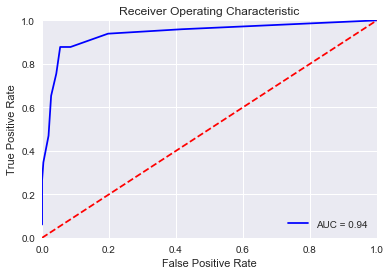

rfClassifierE P:[ 0.12662338  0.65306122  1.        ] R:[ 1.          0.82051282  0.        ]
Confusion matrix, without normalization
[[252   7]
 [ 17  32]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.35  0.65]]


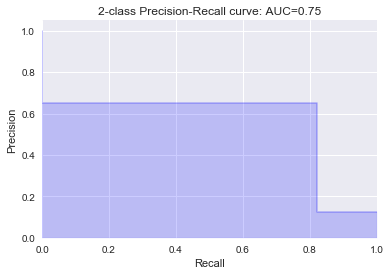

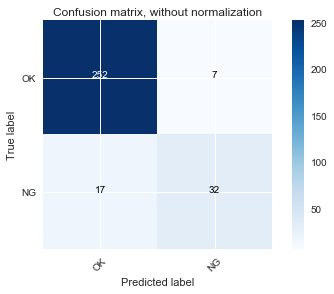

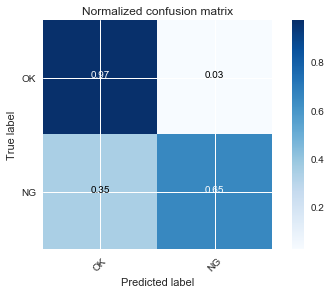

In [14]:
rfClassifierE = RandomForestClassifier()
rfClassifierE.fit(x_train, y_train)
plot_ROC(rfClassifierE, x_test, y_test)
draw_prcurve(rfClassifierE.predict(x_test), y_test, 'b', 'rfClassifierE')
test_model2(rfClassifierE, x_test, y_test)

In [15]:
from sklearn.metrics import f1_score
print(f1_score(y_test, rfClassifierE.predict(x_test)))

0.727272727273


# Tunning

튜닝된 결과<br>
GridSearch를 통해 RandomForest의 모델을 튜닝한 결과,

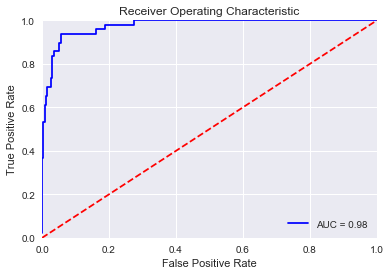

rfClassifierE P:[ 0.15  0.78  1.  ] R:[ 1.    0.83  0.  ]
Confusion matrix, without normalization
[[251   8]
 [ 11  38]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.22  0.78]]


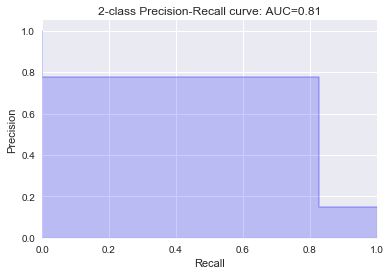

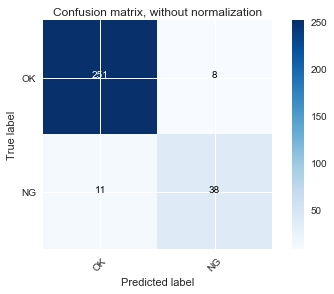

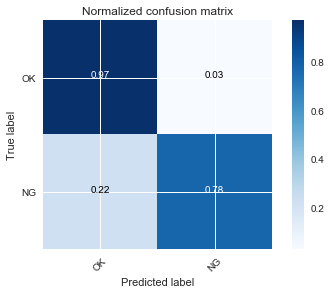

In [16]:
plot_ROC(clf, x_test, y_test)
draw_prcurve(clf.predict(x_test), y_test, 'b', 'rfClassifierE')
test_model2(clf, x_test, y_test)

In [17]:
from sklearn.metrics import f1_score
print(f1_score(y_test, clf.predict(x_test)))

0.8


# Tunning Parameter

In [18]:
print(clf.best_params_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'n_estimators': 512, 'n_jobs': -1}
